# Support Vector Machine
***

In this notebook we will approach the prediction problem using SVMs.

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.model_selection as skm
import sklearn as sk
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [145]:
train_data = pd.read_csv('data/processedTrain.csv')
train_data.head()


,Age,Fare,PassengerId,Survived,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,2,0,1,0.0,1,0,0.383838,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,11,2,1.0,2,1,1.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,3,3,1.0,1,0,0.383838,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,7,10,4,1.0,2,1,0.383838,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,7,3,5,0.0,1,0,0.383838,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [146]:
test_data = pd.read_csv('data/processedTest.csv')
test_data.drop(columns='Survived',inplace =True)
test_data.head()

,Age,Fare,PassengerId,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,7,2,892,1,0,0.383838,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,8,0,893,1,1,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,9,4,894,1,0,0.383838,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,5,4,895,1,0,0.383838,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2,5,896,2,1,1.000000,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


We check if there is any missing data:

In [147]:
train_data.isna().sum()

Age                      0
Fare                     0
PassengerId              0
Survived                 0
Ticket_Frequency         0
Is_Married               0
Survival_Rate            0
Survival_Rate_NA         0
Pclass_1                 0
Pclass_2                 0
Pclass_3                 0
Sex_1                    0
Sex_2                    0
Deck_1                   0
Deck_2                   0
Deck_3                   0
Deck_4                   0
Embarked_1               0
Embarked_2               0
Embarked_3               0
Title_1                  0
Title_2                  0
Title_3                  0
Title_4                  0
Family_Size_Grouped_1    0
Family_Size_Grouped_2    0
Family_Size_Grouped_3    0
Family_Size_Grouped_4    0
dtype: int64

We convert the targets into an appropriate format and split the data into training and test data (80/20 split).

In [148]:
# Y = np.where(train_data['Survived']==0, -1, train_data['Survived']) # Survived 1, Died is -1

# X = train_data.drop(columns='Survived') # Chosen features
# X = pd.get_dummies(X)
# print(X)


y_train = train_data['Survived'].values
X_train = StandardScaler().fit_transform(train_data.drop(columns=['Survived','PassengerId']))

X_final = StandardScaler().fit_transform(test_data.drop(columns=['PassengerId']))
X = X_train 
Y = y_train
X_train, X_test, y_train, y_test = skm.train_test_split(X, Y, test_size=0.3, random_state=42) # Test:Train is 2:8


In [149]:
X_final.shape
# X_test.shape

(418, 26)

### Linear Kernel
***

We begin by fitting a support vector machine with linear kernel.

In [150]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=10, kernel='linear')

We perform K(=5)-fold cross validation in order to find a suitable regularisation parameter.

In [151]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)

grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.005,0.01,0.1,1]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=10, kernel='linear'),
             param_grid={'C': [0.001, 0.005, 0.01, 0.1, 1]},
             scoring='accuracy')

In [152]:
print('The best parameter is given by: {}'.format(grid.best_params_['C'])) 
print('The scores are:', grid.cv_results_[('mean_test_score')])

The best parameter is given by: 1
The scores are: [0.81540645 0.83468387 0.83307097 0.8556     0.8588    ]


Let's see how the model fares on the training data:

In [153]:
best_ = grid.best_estimator_
best_.score(X_test, y_test)

0.8395522388059702

We check out how well this performs on the test data with the aid of a confusion matrix. Definition are included below for clarity.

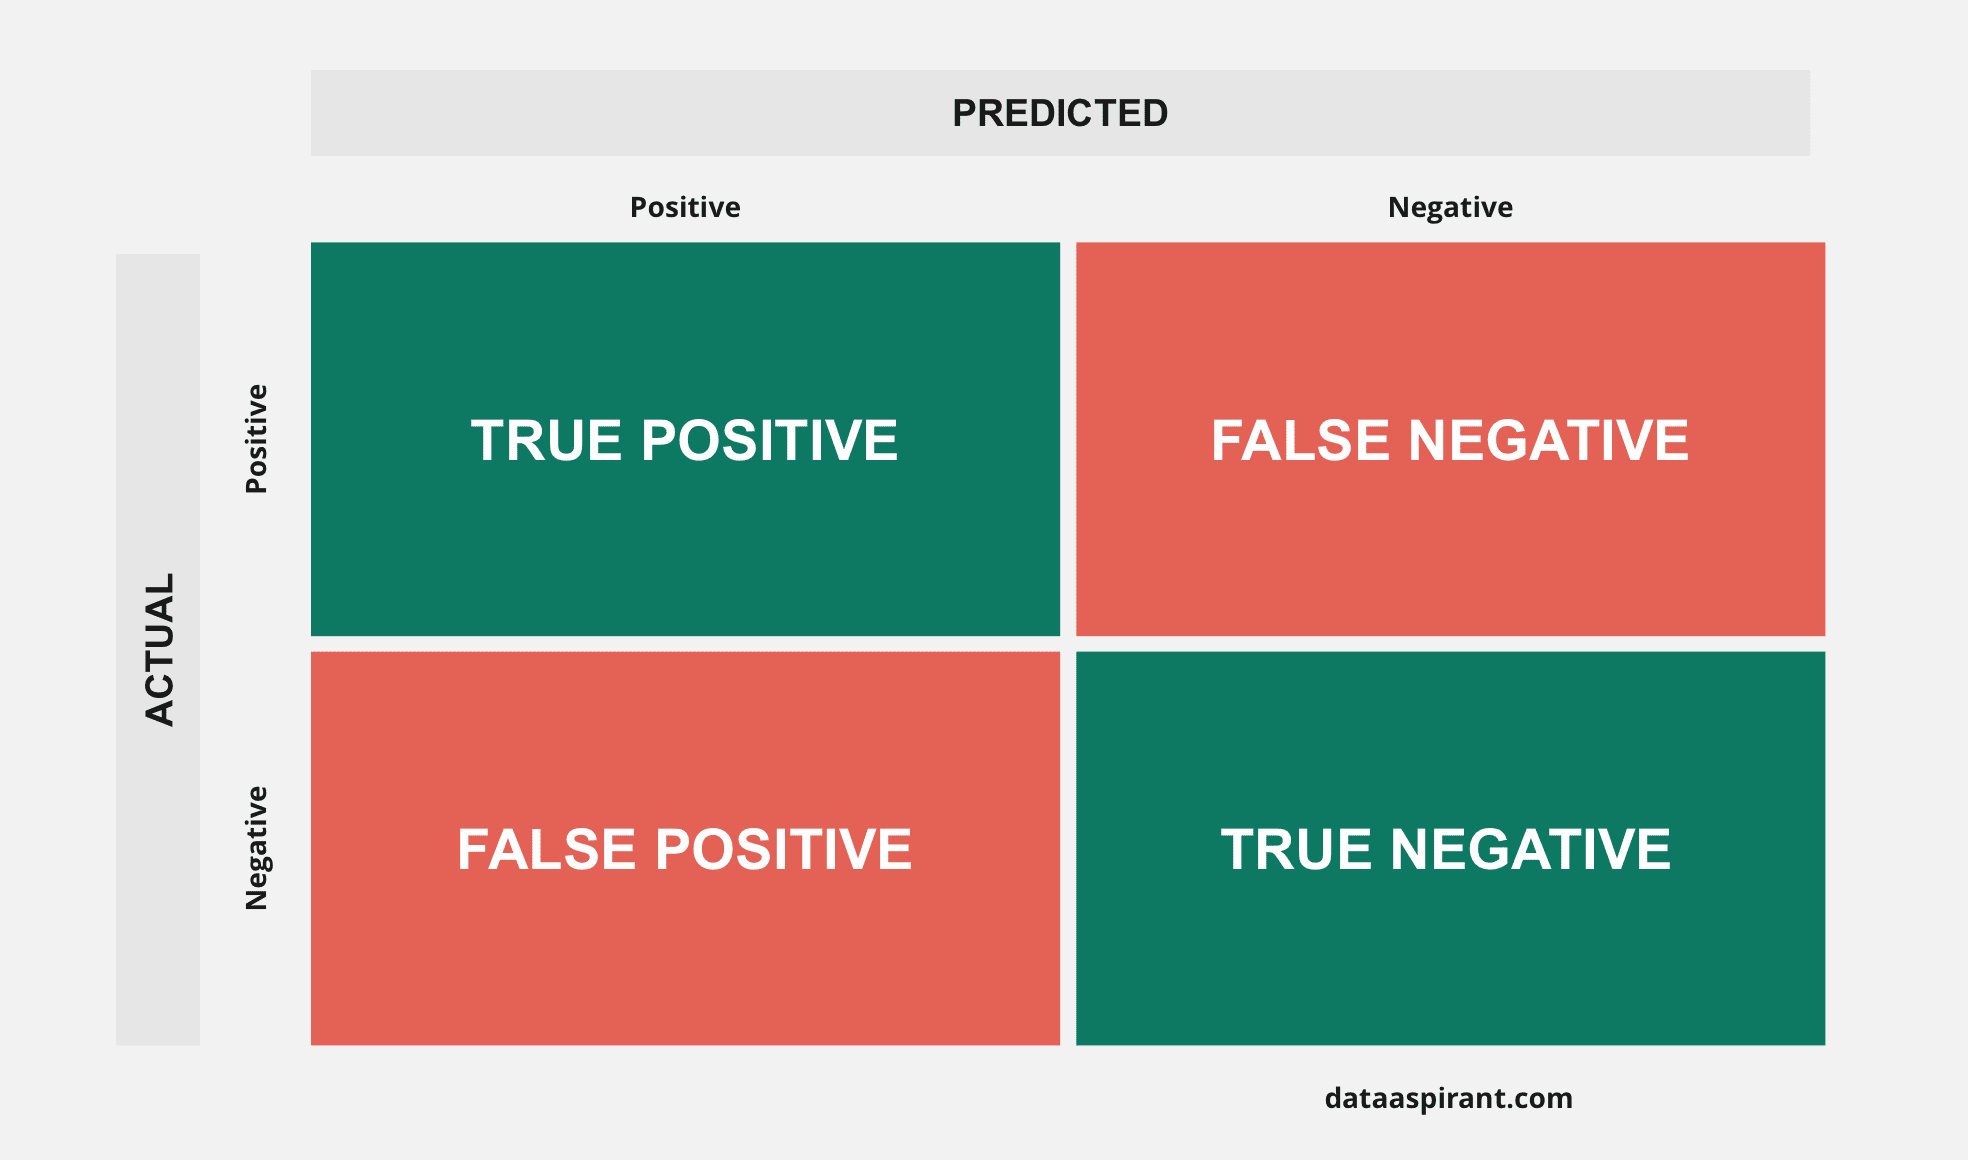

**Definition** 

The True Positive Rate (TPR), False Negative Rate (FPR), True Negative Rate (TNR), and False Negative Rate (FNR) are given by
$$
\begin{gathered}
T P R=\frac{T P}{\text { Actual Positive }}=\frac{T P}{T P+F N} \\
F N R=\frac{F N}{\text { Actual Positive }}=\frac{F N}{T P+F N} \\
T N R=\frac{T N}{\text { Actual Negative }}=\frac{T N}{T N+F P} \\
F P R=\frac{F P}{\text { Actual Negative }}=\frac{F P}{T N+F P}
\end{gathered}
$$


**Definition (Precision)**

Out of all the positive predicted, *Precision* is the percentage that is truly positive. It is the same as *Positive Predictive Rate*.
$$
\text { Precision }=\frac{T P}{T P+F P}
$$


**Definition (Recall)**

Out of the total positive, *Recall* is the percentage that is predicted positive. It is the same as TPR (true positive rate) and *Sensitivity*.
$$
\text { Recall }=\frac{T P}{T P+F N}
$$


**Definition (Specificity)**

Out of the total negative, *Specificity* is the percentage that is predicted negative. It is the same as TNR (true negative rate).
$$
\text { Specificity }=\frac{T N}{T N+F P}
$$


The fraction of correct predictions is 0.84
The precision is 0.82
The recall is 0.78
The specificity is 0.85


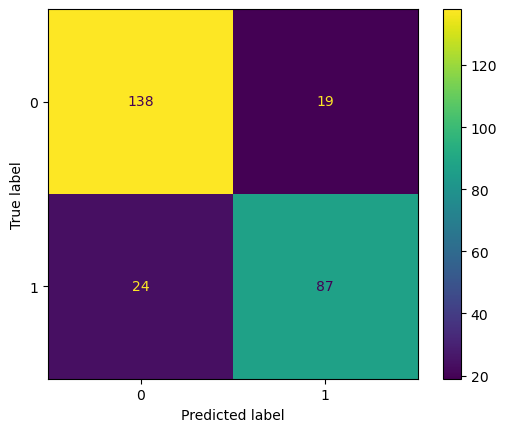

In [170]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
CM = sk.metrics.confusion_matrix( y_test, y_test_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

In [171]:
predictions = best_.predict(X_final).astype(int)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

Your submission was successfully saved!


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Change of kernel
***
We now do the same as before, but try different kernels and tune hyper-parameters.

We use GridSearchCV and try $C$ and $\gamma$ values that range from 0.1 to 10 with rbf and sigmoid kernels.
***
RESULT: {'C': 0.5, 'gamma': 0.5, 'kernel': 'rbf'}
***

In [155]:
model = SVC(probability=True, random_state=0)

# We try (5*5*3=)75 parameter combinations
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': [0.1, 0.5, 1, 5, 10],
    'kernel': ['rbf', 'sigmoid','linear']
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=5,verbose=2)
grid_search.fit(X_train, y_train) 

best_model = grid_search.best_estimator_ 

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, 

In [156]:
grid_search.best_params_

{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}

The following shows that we perform worse on the test data!

The fraction of correct predictions is 0.84
The precision is 0.85
The recall is 0.74
The specificity is 0.83


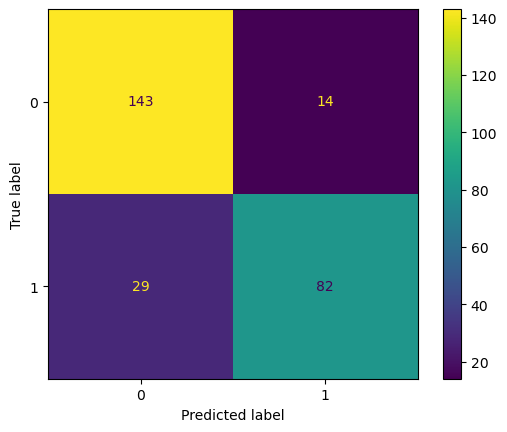

In [157]:
best_ = grid_search.best_estimator_
y_test_hat = best_.predict(X_test)
CM = sk.metrics.confusion_matrix( y_test, y_test_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

Let's try and narrow our search to see if we get a higher performance.

In [176]:
from sklearn.feature_selection import SequentialFeatureSelector

model = SVC(kernel='rbf',probability=True, random_state=0)

param_grid = {
    'C': [1,2,3, 4, 5,6,7],
    'gamma': [0.01, 0.15, 0.1, 0.05, 0.5]
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train) 

best_model = grid_search.best_estimator_ 
grid_search.best_params_

{'C': 7, 'gamma': 0.01}

The fraction of correct predictions is 0.85
The precision is 0.86
The recall is 0.76
The specificity is 0.84


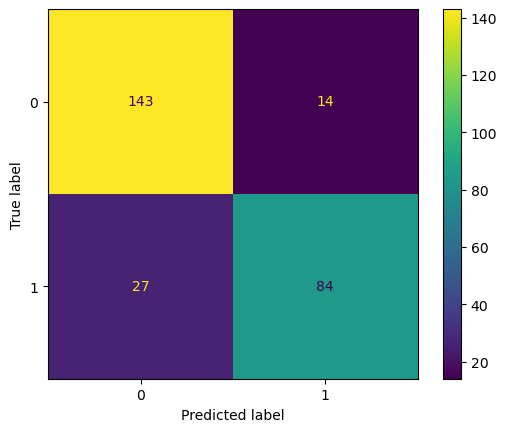

In [177]:
best_ = grid_search.best_estimator_
y_test_hat = best_.predict(X_test)
CM = sk.metrics.confusion_matrix( y_test, y_test_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

In [165]:
SVC(kernel='rbf','C'=2,'gamma'=0.1,probability=True, random_state=0).fit(X, Y) 


Your submission was successfully saved!


,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [178]:
predictions = best_.predict(X_final).astype(int)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

Your submission was successfully saved!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


This is as good as the benchmark. Let's try and reduce the number of features.

## Feature Selection
***

We try forward selection.

In [168]:
from sklearn.feature_selection import SequentialFeatureSelector

C = [1,2,3,4,5]
gamma = [0.01,0.1,0.5,1,2]
arr = np.zeros(22)

for x in C:
    for y in gamma:
        svm = SVC(C=x, gamma=y, kernel='rbf')
        sfs = SequentialFeatureSelector(svm, n_features_to_select=4)
        sfs.fit(X_train, y_train)
        arr = arr + np.array(list(map(int,sfs.get_support())))

counts = arr.copy()
hashMap = {x:i for i,x in enumerate(counts)}
counts.sort()
index = [hashMap[counts[-1]], hashMap[counts[-2]], hashMap[counts[-3]], hashMap[counts[-4]]]
newX_train = X_train.iloc[:,index]


ValueError: operands could not be broadcast together with shapes (22,) (26,) 

We try and find good parameters for the chosen features:

In [ ]:
model = SVC(kernel='rbf',probability=True, random_state=0)

param_grid = {
    'C': [0.1,1,2,3,4, 5, 6],
    'gamma': [0.001,0.01,0.05,0.1,0.15,0.2,0.5]
}

grid_search = skm.GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(newX_train, y_train) 

best_model = grid_search.best_estimator_ 
grid_search.best_params_

{'C': 4, 'gamma': 0.5}

Check performance:

In [66]:
best_ = grid_search.best_estimator_
y_test_hat = best_.predict(X_test.iloc[:,index])
CM = sk.metrics.confusion_matrix( y_test, y_test_hat )
sk.metrics.ConfusionMatrixDisplay(CM).plot()
print("The fraction of correct predictions is {0:.2}".format((CM[0][0]+CM[1][1])/(CM[0][0]+CM[1][1]+CM[0][1]+CM[1][0])))
print("The precision is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[0][1])))
print("The recall is {0:.2}".format((CM[1][1])/(CM[1][1]+CM[1][0])))
print("The specificity is {0:.2}".format(CM[0][0]/(CM[0][0]+CM[1][0])))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

We are now 2% better than the benchmark of 78%

In [48]:
X_test = StandardScaler().fit_transform(test_data)
predictions = best_.predict(X_test)
# predictions = np.where( predictions == -1, 0 ,predictions )
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

ValueError: X has 26 features, but SVC is expecting 27 features as input.

In [ ]:
import keras